In [288]:
import numpy as np
import matplotlib.pyplot as plt
import os

#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(dname)


In [289]:
def load_data(name):
    labels = []
    images = []
    with open(name, 'r') as f:
        for row in f:
            row = row.strip().split(' ')
            row=np.array(row).astype(float)
            #print(row.shape)
            
            label=row[0]
            image = row[1:]
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

def featExtrct(name):

    images, labels = load_data(name)
    print(images.shape)
    images = images.reshape(-1, 16, 16)
    
    
    # Extract feature

    #intensity feature
    inten = images.reshape(-1, 16*16).mean(axis=-1)

    #symmetry feature    
    symall=[]
    for i in range(len(images)):
        sym1 = np.abs(np.fliplr(images[i]) - images[i]) +np.abs(np.flipud(images[i]) - images[i])
    
        symall.append(sym1)
    symall=np.array(symall)
    print(symall.shape) 
    sym=np.array(symall.reshape(len(images),-1).mean(axis=-1))
    print('sym shape') 
    print(sym.shape)

    #plotting features
    i1 = (labels == 1)
    i5 = (labels != 1)
    
    labels = np.zeros(len(labels))
    labels[i1] = 1
    labels[i5] = -1    
    
    featvector = np.concatenate((inten[:, None], sym[:, None]), axis=1)      

    
    plt.figure()
    plt.scatter(inten[i1], sym[i1], c='b', marker='o', label='digit 1 feature')
    plt.scatter(inten[i5], sym[i5], c='r', marker='x', label='digit NOT 1 feature')
    plt.legend()
    plt.xlabel('Intensity')
    plt.ylabel('Vertical Symmetry')
    plt.title('For the file named:'+name)
    plt.show()

    
    
    return featvector, labels

    

(7291, 256)
(7291, 16, 16)
sym shape
(7291,)


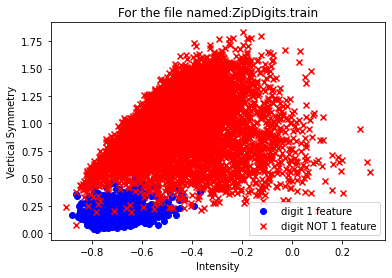

(2007, 256)
(2007, 16, 16)
sym shape
(2007,)


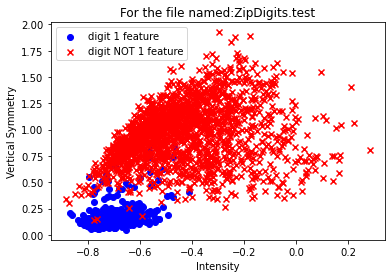

(9298, 2)


In [290]:
trainfile = 'ZipDigits.train'
testfile = 'ZipDigits.test'

#Data collect
traindata, trainlabel= featExtrct(trainfile)
testdata, testlabel=featExtrct(testfile)


#Creating single dataset
dataset = np.concatenate((traindata, testdata), axis=0)
labels= np.concatenate((trainlabel, testlabel), axis=0)



print(dataset.shape)



In [291]:
#Mapping from -1 to +1

dataset[:,0]=np.interp(dataset[:,0], (dataset[:,0].min(), dataset[:,0].max()), (-1, +1))
dataset[:,1]=np.interp(dataset[:,1], (dataset[:,1].min(), dataset[:,1].max()), (-1, +1))



#Splitting dataset

import random
random.seed(0)
a=random.sample(range(len(dataset)), 300)
b=np.arange(0,len(dataset))
c=np.delete(b,a) 

traindata=dataset[a]
trainlabel=labels[a]

testdata=dataset[c]
testlabel=labels[c]

print(len(trainlabel[trainlabel==-1]))

assert len(traindata)==300


253


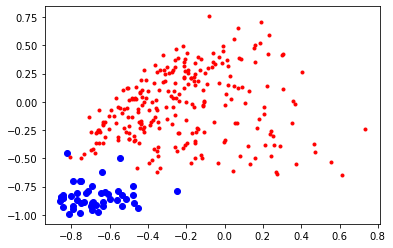

In [292]:
i1 = (trainlabel == 1)
i5 = (trainlabel != 1)
plt.figure()
plt.scatter(traindata[:,0][i1], traindata[:,1][i1], c='b', marker='o', label='digit 1 feature')
plt.scatter(traindata[:,0][i5], traindata[:,1][i5], c='r', marker='.', label='digit 5 feature')


In [293]:
#Calculate Legendre Polynomial

def legendre_val(x,k):
    if k==0:
        return 1
    elif k==1:
        return x
    else:
        return (2*k-1)/k*x*legendre_val(x,k-1)-(k-1)/k*legendre_val(x,k-2)

def calc_legendre(data,degree):
    x=data[:,0]
    y=data[:,1]
    total_feature=int((degree+1)*(degree+2)/2)
    Z=np.zeros((data.shape[0],total_feature))
    num=0
    for i in range(degree):
        for j in range(degree):
            if j+i<=8:
                Lx=legendre_val(x,i)
                Ly=legendre_val(y,j)
                Z[:,num]=Lx*Ly
                num+=1
    return Z


In [294]:
#Decision Boundary

def decision_boundary(w,features,label, name=''):
    x1 = np.linspace(-1, 1, 100)
    x2 = np.linspace(-1, 1, 100)
    x1, x2 = np.meshgrid(x1, x2)
    data = np.array([x1.ravel(), x2.ravel()]).T
    Z_bound=calc_legendre(data,8)
    z=np.dot(Z_bound,w)
    z = z.reshape(x1.shape)    
    plt.figure()
    plt.contour(x1, x2, z, [0])
    
    plt.scatter(features[:,0][label==1], features[:,1][label==1], c='b',marker='o',label='digit 1')
    plt.scatter(features[:,0][label==-1], features[:,1][label==-1], c='r',marker='x',label='digit NOT 1')
    plt.xlabel('Intensity')
    plt.ylabel('Symmetry')
    plt.title(name)
    
    plt.legend()

In [295]:
Z_train=calc_legendre(traindata,8)
Z_test=calc_legendre(testdata,8)
print(f"Dimension of Z:{Z_train.shape}")

Dimension of Z:(300, 45)


Training Error: 0.036320079842377964
Testing Error: 10.235051582780034


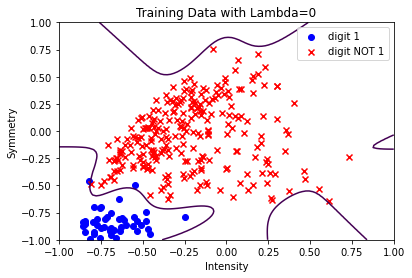

In [296]:

#for lambda=0
lamda=0

w_no_reg = np.linalg.pinv(Z_train.transpose() @ Z_train + lamda * np.eye(Z_train.shape[1]) ) @ Z_train.transpose() @ trainlabel

train_pred = np.dot(Z_train, w_with_reg)

train_error = np.mean(np.power(train_pred - trainlabel, 2))



# test error

test_pred = np.dot(Z_test, w_no_reg)
test_error = np.mean(np.power(test_pred - testlabel, 2))


print(f"Training Error: {train_error}")
print(f"Testing Error: {test_error}")

decision_boundary(w_no_reg,traindata,trainlabel,name='Training Data with Lambda=0')





Training Error: 0.03597503156955265
Testing Error: 0.05420356969682487


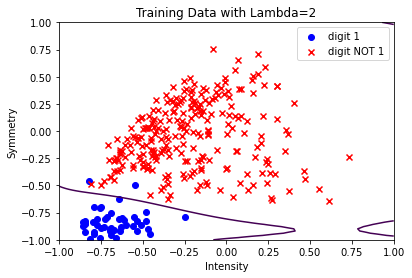

In [297]:

#for lambda=2
lamda=2

w_with_reg = np.linalg.pinv(Z_train.transpose() @ Z_train + lamda * np.eye(Z_train.shape[1]) ) @ Z_train.transpose() @ trainlabel


train_pred = np.dot(Z_train, w_with_reg)


train_error = np.mean(np.power(train_pred - trainlabel, 2))



# test error

test_pred = np.dot(Z_test, w_with_reg)
test_error = np.mean(np.power(test_pred - testlabel, 2))


print(f"Training Error: {train_error}")
print(f"Testing Error: {test_error}")


decision_boundary(w_with_reg,traindata,trainlabel,name='Training Data with Lambda=2')

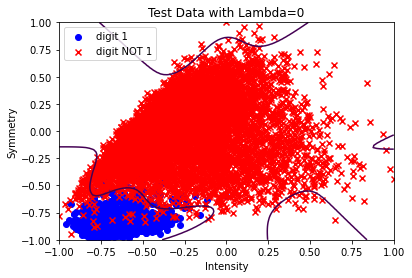

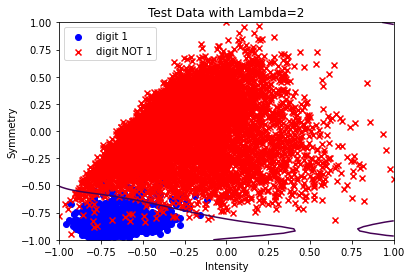

In [298]:
decision_boundary(w_no_reg,testdata,testlabel,name='Test Data with Lambda=0')
decision_boundary(w_with_reg,testdata,testlabel,name='Test Data with Lambda=2')

<ipython-input-299-da35ddf78e59>:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(lamdas[:],cv_errors[:],c='b',LineStyle='dashed',label='CV error')
<ipython-input-299-da35ddf78e59>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(lamdas[1:],cv_errors[1:],c='b',LineStyle='dashed',label='CV error')


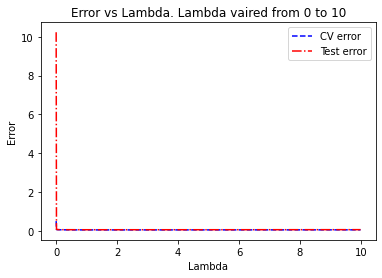

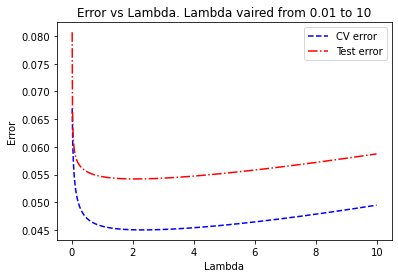

In [299]:
#Cross Validation

lamdas=np.arange(0,10,0.01)

test_errors=np.zeros(len(lamdas))
cv_errors=np.zeros(len(lamdas))

for i,lam in enumerate(lamdas):
    w_minus = np.linalg.pinv(Z_train.transpose() @ Z_train + lam * np.eye(Z_train.shape[1]) ) @ Z_train.transpose() 
    w_with_reg=w_minus@ trainlabel
    H_lamda=Z_train @ w_minus
    
    train_pred = np.dot(Z_train, w_with_reg)
    
    cv_error = np.mean(np.power((train_pred - trainlabel)/(1-H_lamda.diagonal()), 2))
    

    
    test_pred = np.dot(Z_test, w_with_reg)
    test_error = np.mean(np.power(test_pred - testlabel, 2))
    test_errors[i]=test_error
    cv_errors[i]=cv_error

plt.figure()

plt.plot(lamdas[:],cv_errors[:],c='b',LineStyle='dashed',label='CV error')
plt.plot(lamdas[:],test_errors[:],c='r',ls='dashdot',label='Test error') 
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.title('Error vs Lambda. Lambda vaired from 0 to 10')
plt.legend()


plt.figure()

plt.plot(lamdas[1:],cv_errors[1:],c='b',LineStyle='dashed',label='CV error')
plt.plot(lamdas[1:],test_errors[1:],c='r',ls='dashdot',label='Test error') 
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.title('Error vs Lambda. Lambda vaired from 0.01 to 10')
plt.legend()




In [300]:
print(lamdas[np.argmin(cv_errors)])
print(cv_errors[np.argmin(cv_errors)])
print(test_errors[np.argmin(cv_errors)])
print(min(test_errors))


2.32
0.04500653196952515
0.05421397795769778
0.05420212652857066


Number of test points:8998
misclassified test points:138
Classification Error: 0.01533674149811069


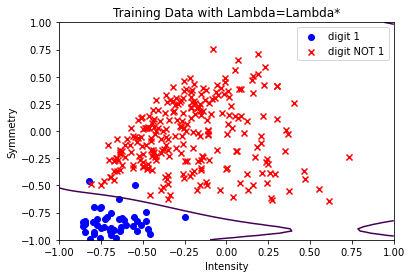

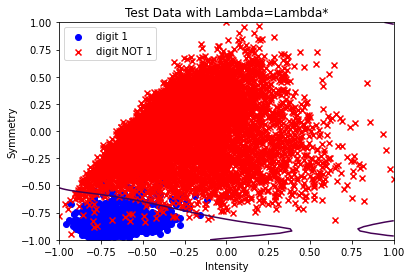

In [301]:
lamda=lamdas[np.argmin(cv_errors)]

w_with_reg = np.linalg.pinv(Z_train.transpose() @ Z_train + lamda * np.eye(Z_train.shape[1]) ) @ Z_train.transpose() @ trainlabel


train_pred = np.dot(Z_train, w_with_reg)


train_error = np.mean(np.power(train_pred - trainlabel, 2))



# Classification test error

test_pred = np.sign(np.dot(Z_test, w_with_reg))

#test_error = np.mean(np.power(test_pred - testlabel, 1))

print(f"Number of test points:{len(test_pred)}")

a=test_pred!=testlabel
b=np.mean(a)
a=a[a==True]
print(f"misclassified test points:{len(a)}") #number of misclassified points  


#print(f"Training Error: {train_error}")
print(f"Classification Error: {b}")


decision_boundary(w_with_reg,traindata,trainlabel,name='Training Data with Lambda=Lambda*')
decision_boundary(w_with_reg,testdata,testlabel,name='Test Data with Lambda=Lambda*')